In [3]:
import imaging_behavior_functions
#import odor_behavioral_analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.io
import os
import mat73
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
from scipy.stats import iqr
from PIL import Image
import cv2
from IPython.display import display, clear_output
import time
import seaborn as sns
from scipy.stats import iqr
from scipy.ndimage import gaussian_filter1d
import glob
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tensorflow as tf
from torchsummary import summary

In [4]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/hDeltaB_imaging/qualified_sessions/bar_jump/"
example_path_data = base_path+"20230518-8_hDeltaB_EPG_syntGCAMP7f_fly2_long_jump_15/data/"
example_path_results = base_path+"20230518-8_hDeltaB_EPG_syntGCAMP7f_fly2_long_jump_15/results/"
trial_num = 1
odor_threshold = 5
time_interval_threshold = 16  # Assuming time is in seconds or an equivalent unit
k = 8
window_size = 30

is_mat73, roi_df, dff_raw, kinematics_raw, preprocessed_vars_ds, preprocessed_vars_odor = imaging_behavior_functions.load_intermediate_mat(example_path_data,trial_num)
behav_df = imaging_behavior_functions.make_df_behavior(dff_raw, preprocessed_vars_ds, preprocessed_vars_odor,trial_num,ball_d = 9)
xPos, yPos = imaging_behavior_functions.reconstruct_path(behav_df, ball_d = 9)
roi_names, hdeltab_index, epg_index, hdeltab_sequence, epg_sequence = imaging_behavior_functions.get_roi_seq(roi_df)
dff_all_rois, dff_time = imaging_behavior_functions.load_dff_raw(is_mat73, dff_raw)
neural_df = imaging_behavior_functions.make_df_neural(dff_all_rois, dff_time, roi_names, hdeltab_index, epg_index, hdeltab_sequence, epg_sequence)
#behav_df, padded_result_df, smoothed_df = odor_behavioral_analysis.analysis_dfs(behav_df, time_interval_threshold, k, window_size)
combined_df = imaging_behavior_functions.combine_df(behav_df, neural_df)
#smoothed_df["translationalV_smoothed"] = np.sqrt(smoothed_df["fwV_smoothed"]**2+smoothed_df["sideV_smoothed"]**2)

In [5]:
behav_df

,time,fwV,sideV,yawV,heading,abssideV,absyawV,net_motion,net_motion_state,heading_adj,odor,xPos,yPos
0,0.000000,0.000000,0.000000,0.000000,0.807151,0.000000,0.000000,0.000000,0,0.807151,0,0.000000,0.000000
1,0.291870,11.753731,37.160649,17.206500,1.298002,37.160649,17.206500,66.120879,1,1.298002,0,2.432251,3.272823
2,0.583740,12.537765,-8.556545,2.081661,1.927763,8.556545,2.081661,23.175971,1,1.927763,0,5.541825,4.929670
3,0.875611,7.791340,-33.120720,-18.771120,1.364153,33.120720,18.771120,59.683180,1,1.364153,0,6.004468,6.688089
4,1.167481,4.919451,-14.949996,-10.064544,0.250982,14.949996,10.064544,29.933991,1,0.250982,0,5.168563,7.573785
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2051,598.625875,12.673073,8.352413,-1.901535,0.653657,8.352413,1.901535,22.927021,1,32.069584,0,735.839759,-37.929081
2052,598.917745,13.890393,-7.833791,2.212717,0.589752,7.833791,2.212717,23.936902,1,32.005678,0,734.868703,-34.121698
2053,599.209615,13.867598,-1.372320,-1.348758,0.685651,1.372320,1.348758,16.588676,1,32.101578,0,734.358752,-30.128773
2054,599.501486,13.571431,-6.711998,-6.721207,0.524856,6.711998,6.721207,27.004636,1,31.940782,0,733.181160,-26.459260


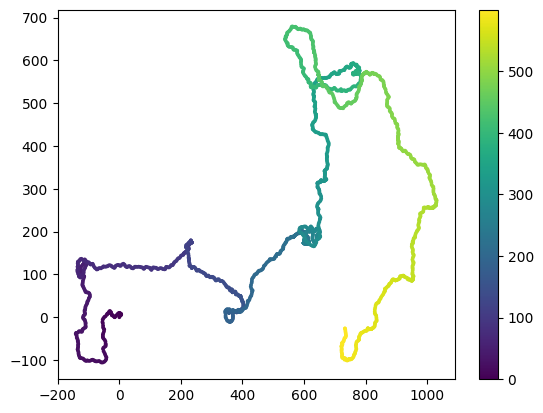

In [6]:
fig = plt.scatter(behav_df.xPos,behav_df.yPos,s=3,c = behav_df.time)
plt.colorbar(fig)

In [7]:
jumpbar_pd = pd.read_csv(example_path_data+'../panel_heading_1.txt',names = ['panel_heading','time','count'])
jumpbar_pd

,panel_heading,time,count
0,0.000000,0.020996,1
1,0.003792,0.027992,2
2,0.022300,0.031990,3
3,0.035174,0.037991,4
4,0.051839,0.041987,5
...,...,...,...
31091,2.752625,617.488348,31092
31092,2.757450,617.508340,31093
31093,2.744913,617.527334,31094
31094,2.742106,617.547328,31095


In [8]:
roi_kw = 'hDeltaB'
roi_mtx = imaging_behavior_functions.extract_heatmap(neural_df, roi_kw, 1, example_path_results, trial_num)
param_df = imaging_behavior_functions.fit_sinusoid(neural_df,roi_mtx)
param_df

,time,phase,baseline,amplitude,phase_error,baseline_error,amplitude_error
0,0.000000,4.084070,1.116697,1.867425,0.080673,0.107223,0.152615
1,0.291870,4.084070,1.335078,1.929972,0.087163,0.119770,0.170530
2,0.583740,4.084070,1.480017,2.051564,0.090384,0.131815,0.187395
3,0.875611,4.084070,1.487417,2.144154,0.084636,0.128767,0.182734
4,1.167481,4.084070,1.430167,2.147832,0.077608,0.118153,0.167498
...,...,...,...,...,...,...,...
2051,598.625875,4.712389,0.245353,2.038301,0.119355,0.176056,0.254553
2052,598.917745,4.712389,0.226084,2.056753,0.113756,0.169316,0.244808
2053,599.209615,4.712389,0.197478,1.981446,0.116036,0.166394,0.240604
2054,599.501486,4.712389,0.220335,1.924240,0.121148,0.168708,0.243941


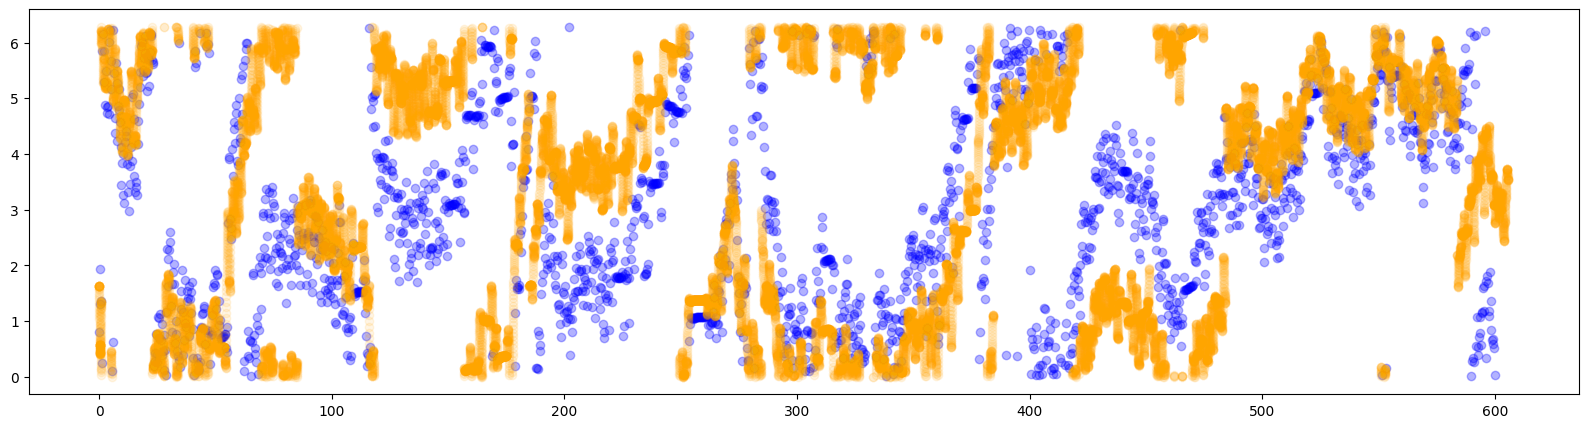

In [16]:
fig_ex, ax = plt.subplots(figsize=[20,5])
x1 = 3000
x2 = 600
ax.scatter(behav_df.time[0:len(behav_df)], behav_df.heading[0:len(behav_df)],color ='blue',alpha = 0.3)
ax.scatter(jumpbar_pd.time[:len(jumpbar_pd)-x2], 2*np.pi-jumpbar_pd.panel_heading[x2:len(jumpbar_pd)],color ='orange',alpha = 0.1)


In [17]:
heading_intp = np.interp(behav_df.time, jumpbar_pd.time[:-x2], 2*np.pi-jumpbar_pd.panel_heading[x2:])
behav_df['heading_jump'] = heading_intp

In [18]:
heading_adj = 2*np.pi-jumpbar_pd.panel_heading[x2:]
jump_label = np.abs(np.diff(np.unwrap(heading_adj)))>2 
jump_idx = np.where(jump_label)

Text(0, 0.5, 'fw velocity (mm/s)')

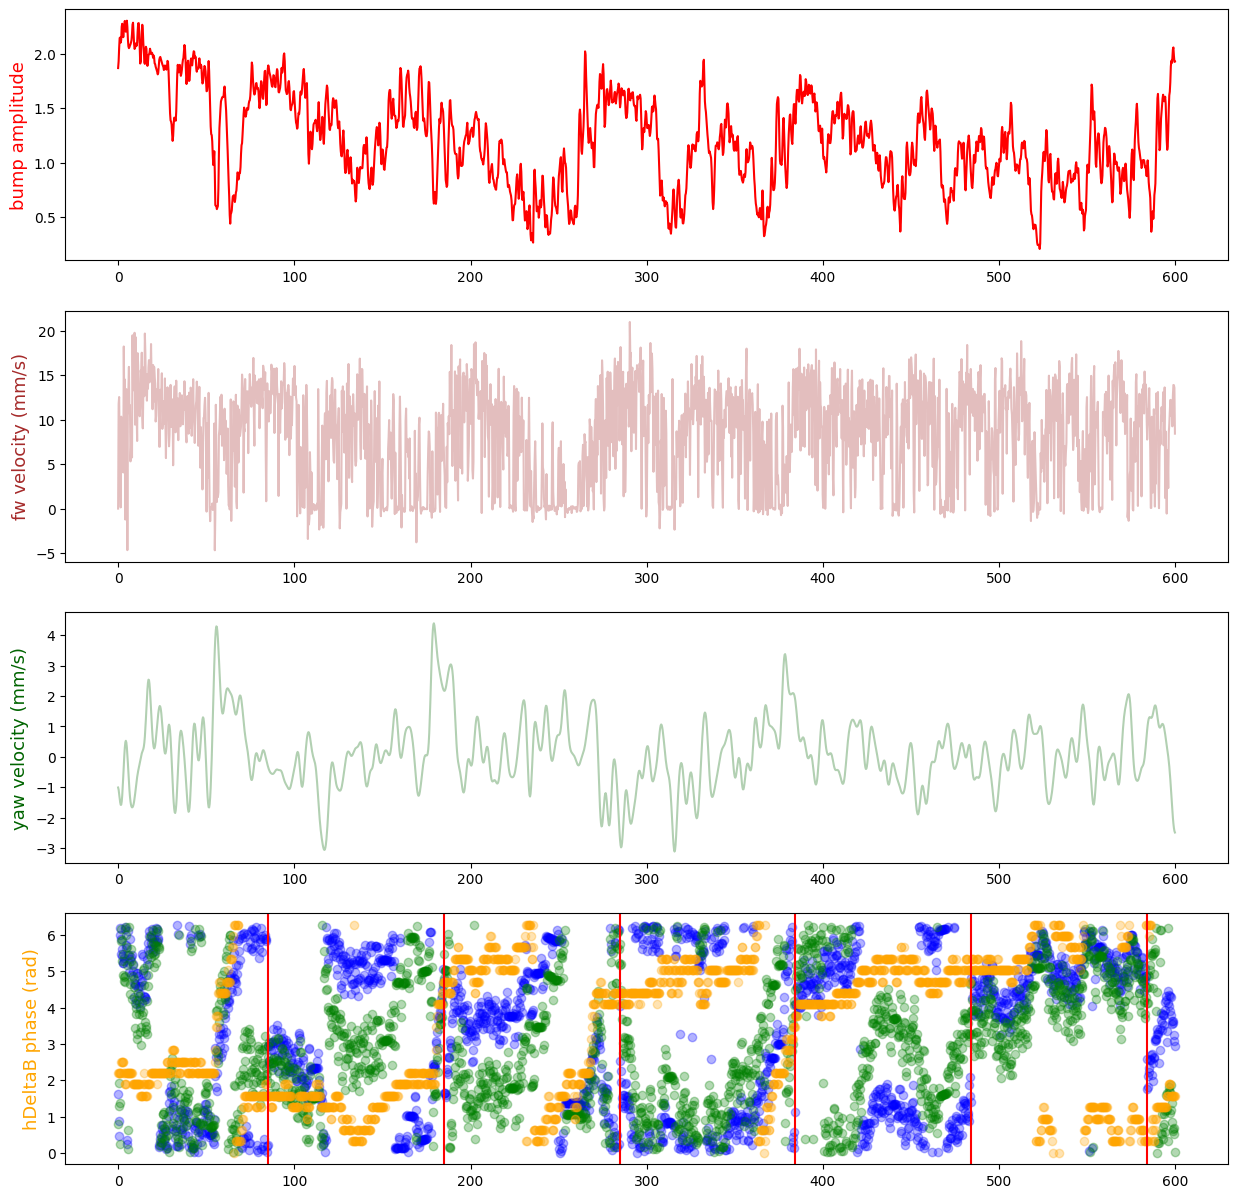

In [20]:
fig_ex, ax = plt.subplots(4,1,figsize=[15,15])
ind1 = 0
ind2 = len(behav_df) 
ax[0].plot(behav_df.time[ind1:ind2], param_df.amplitude[ind1:ind2],color = 'red')
ax[0].set_ylabel('bump amplitude', fontsize = 13, color = 'red')
ax[3].scatter(behav_df.time[ind1:ind2], heading_intp[ind1:ind2],color ='blue',alpha = 0.3)
ax[3].scatter(behav_df.time[ind1:ind2], behav_df.heading[ind1:ind2],color ='green',alpha = 0.3)
ax[3].scatter(behav_df.time[ind1:ind2], 2*np.pi-param_df.phase[ind1:ind2],color ='orange',alpha = 0.3)
#ax[3].scatter(jumpbar_pd.time[:-600], 2*np.pi-jumpbar_pd.panel_heading[600:],color ='orange',alpha = 0.1)
for i in range(len(jump_idx[0])):
    ax[3].axvline(jumpbar_pd.time[jump_idx[0][i]],color ='red')
ax[3].set_ylabel('hDeltaB phase (rad)', fontsize = 13, color = 'orange')
#ax2 = ax[3].twinx()
ax[2].plot(behav_df.time[ind1:ind2], imaging_behavior_functions.apply_gaussian_smoothing(behav_df.yawV[ind1:ind2],5),color='darkgreen',alpha = 0.3)
ax[2].set_ylabel('yaw velocity (mm/s)', fontsize = 13, color = 'darkgreen')
ax[1].plot(behav_df.time[ind1:ind2],behav_df.fwV[ind1:ind2], color = 'brown',alpha = 0.3)
ax[1].set_ylabel('fw velocity (mm/s)', fontsize = 13, color = 'brown')

In [13]:
# Function to find the index of the closest value
def find_closest_indices(values, highlight_values):
    indices = []
    for value in highlight_values:
        # Compute absolute difference and find the index of the minimum
        index = np.abs(values - value).argmin()
        indices.append(index)
    return indices

In [14]:
highlight_times = np.array(jumpbar_pd.time[jump_idx[0]])
# Find the index of the closest value for each highlight value
highlight_indices = find_closest_indices(behav_df.time, highlight_times)

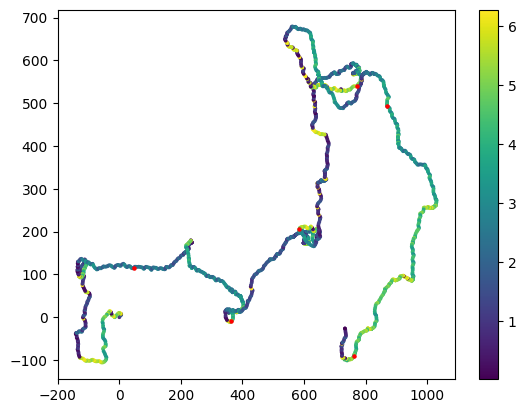

In [15]:
fig = plt.scatter(xPos,yPos,s=3,c = behav_df.heading)
# Highlight specific time points in red
for idx in highlight_indices:
    plt.scatter(xPos[idx], yPos[idx], s=5,color='red')
plt.colorbar(fig)